# Extending the agc-autodiff pipeline with correctionlib

This notebook demonstrates how to use correctionlib in the dummy data analysis pipeline of agc-autodiff:
- There is already a differentiable version of correctionlib from Enrico: https://github.com/eguiraud/correctionlib-gradients/
- However, it has limitations and doesn't work for this pipeline out-of-the-box
- This notebook demonstrates how to integrate correctionlib-gradients into the existing pipeline, what problems are encoutered, and how fix them
- My extensions to correctionlib-gradients can be found in this PR https://github.com/eguiraud/correctionlib-gradients/pull/62

In [1]:
import awkward as ak
import hist
import jax
import matplotlib.pyplot as plt
import numpy as np
import uproot
import vector
import urllib
import rich
import correctionlib
from correctionlib import schemav2
from tqdm.notebook import tqdm

vector.register_awkward()
ak.jax.register_and_check()

In [2]:
# read in data and apply preselection
ttbar_file = "https://github.com/scikit-hep/scikit-hep-testdata/"\
    "raw/main/src/skhep_testdata/data/nanoAOD_2015_CMS_Open_Data_ttbar.root"

with uproot.open(ttbar_file) as f:
    arr = f["Events"].arrays(["Jet_pt","Jet_eta", "Jet_phi", "Jet_mass"])

evtfilter = ak.num(arr["Jet_pt"]) >= 2
jets = ak.zip(dict(zip(["pt","eta", "phi", "mass"], ak.unzip(arr))), with_name="Momentum4D")[evtfilter]
jets = ak.to_backend(jets, "jax")


In [3]:
print(arr.type.show())
print(jets.type.show())

200 * {
    Jet_pt: var * float32,
    Jet_eta: var * float32,
    Jet_phi: var * float32,
    Jet_mass: var * float32
}
None
140 * var * Momentum4D[
    pt: float32,
    eta: float32,
    phi: float32,
    mass: float32
]
None


In [4]:
# Reminder: the original dummy jet correction function
def correct_jets_original(jets, alpha):
    """perform jet energy calibration with nuisance parameter alpha"""
    jets = ak.Array(jets)
    new_pt = jets["pt"] + 25*alpha
    jets["pt"] = new_pt
    return jets

In [5]:
# Let's implement the correction with the correctionlib framework
schema = schemav2.Correction(
    name="toy_calibration",
    version=1,
    inputs=[
        schemav2.Variable(name="NP", type="real")
    ],
    output=schemav2.Variable(name="shift in pt", type="real"),
    data=schemav2.Formula(
        nodetype="formula",
        expression="25*x",
        parser="TFormula",
        variables=["NP"],
    ),
)

rich.print(schema)

📈 toy_calibration (v1)
No description
Node counts: Formula: 1
╭──────────── ▶ input ────────────╮
│ NP (real)                       │
│ No description                  │
│ Range: [-inf, inf), overflow ok │
╰─────────────────────────────────╯
╭───── ◀ output ─────╮
│ shift in pt (real) │
│ No description     │
╰────────────────────╯

In [6]:
# make new correct_jets() function and validate it
corr = schema.to_evaluator()

def correct_jets(jets, alpha):
    """perform jet energy calibration with nuisance parameter alpha"""
    jets = ak.Array(jets)
    new_pt = jets["pt"] + corr.evaluate(alpha)
    jets["pt"] = new_pt
    return jets

jets_corrected_original = correct_jets_original(jets, 0.1)
jets_corrected = correct_jets(jets, 0.1)

print(jets_corrected_original.pt)
print(jets_corrected.pt)

[[20.421875, 18.234375], ..., [46.9375, 27.71875, ..., 20.1875, 17.984375]]
[[20.421875, 18.234375], ..., [46.9375, 27.71875, ..., 20.1875, 17.984375]]


In [7]:
# implement the rest of the pipeline
def get_trijet_mass(jets, temperature=100.):
    """
    get trijet mass using combination with highest combined pt
    differentiable approximation: replace argmax by softmax and return weighted sum
    temperature -- smaller values make softmax closer to argmax (can get NaN, though)
    """
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
    weights = ak.softmax(1/temperature * trijet.p4.pt, axis=-1)
    return ak.sum(weights * trijet.p4.mass, axis=1)
    # original, non-differentiable version:
    # return trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass


def pipeline(jets, a):
    """analysis pipeline: calculate mean of dijet masses"""
    return np.mean(get_trijet_mass(correct_jets(jets, a)))


In [8]:
# lets try to differentiate the pipeline
val, grad = jax.value_and_grad(pipeline, argnums=1)(jets, 0.1)  # fails because correctionlib is non-differentiable
print(f"val = {val}, grad = {grad}")

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[]
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [9]:
# fix it by replacing correctionlib with correctionlib_gradients
import correctionlib_gradients
from correctionlib_gradients import CorrectionWithGradient

corr = CorrectionWithGradient(schema)
val, grad = jax.value_and_grad(pipeline, argnums=1)(jets, 0.1)
print(f"val = {val}, grad = {grad}")

/Users/linogerlach/Projects/IRIS-HEP/agc-autodiff/venv/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:63: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self._module.asarray(obj, dtype=dtype)
/Users/linogerlach/Projects/IRIS-HEP/agc-autodiff/venv/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:63: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return self._module.asarray(obj, dtype=dtype)


val = 219.3420867919922, grad = 198.30014038085938


In [10]:
# create corrections like on AGC (https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/make_corrections_json.py)
import correctionlib.schemav2 as cs

btag_var_category = cs.Category(
    nodetype="category",
    input="direction",
    content=[
        cs.CategoryItem(
            key="up",
            value=cs.Formula(
                nodetype="formula",
                parser="TFormula",
                variables=["pt"],
                expression="1.0 + (x*0.075 / 50)"
            )
        ),
        cs.CategoryItem(
            key="down",
            value=cs.Formula(
                nodetype="formula",
                parser="TFormula",
                variables=["pt"],
                expression="1.0 - (x*0.075 / 50)"
            )
        ),
    ],
    default=1.0
)

evt_systs = cs.Correction(
    name="event_systematics",
    description="Calculates a multiplicative event weight for the selected systematic variation",
    version=1,
    inputs=[
        cs.Variable(name="syst_name", type="string", description="Systematic name"),
        cs.Variable(name="direction", type="string", description="Variation direction"),
        cs.Variable(name="pt", type="real", description="One specific object pt from each event")
    ],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Category(
        nodetype="category",
        input="syst_name",
        content=[
            cs.CategoryItem(
                key="scale_var",
                value=cs.Category(
                    nodetype="category",
                    input="direction",
                    content=[
                        cs.CategoryItem(
                            key="up",
                            value=1.0 + 0.025
                        ),
                        cs.CategoryItem(
                            key="down",
                            value=1.0 - 0.025
                        ),
                    ],
                    default=1.0
                )
            ),
            cs.CategoryItem(
                key="btag_var",
                value=btag_var_category
            ),
        ],
        default=1.0
    ),
)


In [ ]:
# try to create the correction with gradient
corr_diff = CorrectionWithGradient(evt_systs)  # fails because 'Category' is not supported
# install my version of correctionlib_gradients like so
# pip uninstall correctionlib-gradients
# pip install git+https://github.com/ligerlac/correctionlib-gradients.git@feat_category_with_gradients
# and restart the kernel


In [41]:
# little excursion on categories with gradients

# scale var does not depend on pt. should be (1.0 + 0.025) for 'up' and (1.0 - 0.025) for 'down'
print("expect val=1.025, grad=0")
val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=2)("scale_var", "up", 50.0)
print(f"       val = {val}, grad = {grad}")

print("expect val=0.975, grad=0")
val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=2)("scale_var", "down", 50.0)
print(f"       val = {val}, grad = {grad}")

print("differentiating w.r.t. category should fail")
try:
    val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=1)("scale_var", "down", 50.0)
except TypeError as e:
    print(e)

print("... same for name of variation")
try:
    val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=0)("scale_var", "down", 50.0)
except TypeError as e:
    print(e)

print("expect val=1.075, grad=0.075/50 (0.0015)")
val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=2)("btag_var", "up", 50.0)
print(f"       val = {val}, grad = {grad}")

print("expect val=0.925, grad=-0.075/50 (-0.0015)")
val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=2)("btag_var", "down", 50.0)
print(f"       val = {val}, grad = {grad}")


expect val=1.025, grad=0
       val = 1.025, grad = 0.0
expect val=0.975, grad=0
       val = 0.975, grad = 0.0
differentiating w.r.t. category should fail
Argument 'down' of type <class 'str'> is not a valid JAX type.
... same for name of variation
Argument 'scale_var' of type <class 'str'> is not a valid JAX type.
expect val=1.075, grad=0.075/50 (0.0015)
       val = 1.0750000476837158, grad = 0.001500000013038516
expect val=0.925, grad=-0.075/50 (-0.0015)
       val = 0.925000011920929, grad = -0.001500000013038516


In [116]:
# introduce an NP to the btag sys, so we can optimize w.r.t. it
import correctionlib.schemav2 as cs

btag_var_category = cs.Category(
    nodetype="category",
    input="direction",
    content=[
        cs.CategoryItem(
            key="up",
            value=cs.Formula(
                nodetype="formula",
                parser="TFormula",
                variables=["NP"],
                expression="1.0 * x*x"
            )
        ),
        cs.CategoryItem(
            key="down",
            value=cs.Formula(
                nodetype="formula",
                parser="TFormula",
                variables=["NP"],
                expression="1.0 - x*x"
            )
        ),
    ],
    default=1.0
)

evt_systs = cs.Correction(
    name="event_systematics",
    description="Calculates a multiplicative event weight for the selected systematic variation",
    version=1,
    inputs=[
        cs.Variable(name="syst_name", type="string", description="Systematic name"),
        cs.Variable(name="direction", type="string", description="Variation direction"),
        cs.Variable(name="pt", type="real", description="One specific object pt from each event"),
        cs.Variable(name="NP", type="real", description="Dummy nuisance parameter"),
    ],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Category(
        nodetype="category",
        input="syst_name",
        content=[
            cs.CategoryItem(
                key="scale_var",
                value=cs.Category(
                    nodetype="category",
                    input="direction",
                    content=[
                        cs.CategoryItem(
                            key="up",
                            value=1.0 + 0.025
                        ),
                        cs.CategoryItem(
                            key="down",
                            value=1.0 - 0.025
                        ),
                    ],
                    default=1.0
                )
            ),
            cs.CategoryItem(
                key="btag_var",
                value=btag_var_category
            ),
        ],
        default=1.0
    ),
)

In [118]:
corr_diff = CorrectionWithGradient(evt_systs)

# should be 1+-NP**2 and +- 2*NP
val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=3)("btag_var", "up", 20.0, 0.1)
print(f"val = {val}, grad = {grad}")

val, grad = jax.value_and_grad(corr_diff.evaluate, argnums=3)("btag_var", "down", 20.0, 0.2)
print(f"val = {val}, grad = {grad}")


val = 0.010000000707805157, grad = 0.20000000298023224
val = 0.9599999785423279, grad = -0.4000000059604645


In [190]:
# use the new correction in the pipeline
def correct_jets(jets, alpha):
    """perform jet energy calibration with nuisance parameter alpha"""
    jets = ak.Array(jets)
    new_pt = jets["pt"] * corr_diff.evaluate("btag_var", "up", jets["pt"], alpha)
    jets["pt"] = new_pt
    return jets


np_vals = np.linspace(-5, 5, 20) 
vals_and_grads = np.array([jax.value_and_grad(pipeline, argnums=1)(jets, a) for a in np_vals])
# fails because correctionlib-gradients doesn't handle awkward arrays


TypeError: Unexpected input type for array: <class 'awkward.highlevel.Array'>

In [193]:
# work-around: flatten jet_pt, make jagged array and set content in awkward array 
def correct_jets(jets, alpha):
    """perform jet energy calibration with nuisance parameter alpha"""
    # Get corrections while maintaining gradients
    pt_flat = ak.flatten(jets["pt"]).to_numpy()
    alpha_repeated = jnp.repeat(alpha, pt_flat.size)
    factors = corr_diff.evaluate("btag_var", "up", pt_flat, alpha_repeated)
    corrected_pt_flat = pt_flat * factors

    # Get structure info
    counts = ak.num(jets.pt).to_numpy()
    split_indices = np.cumsum(counts)[:-1]
    corrected_pt_jagged = jnp.split(corrected_pt_flat, split_indices)

    # Create ListOffsetArray directly
    offsets = np.append(0, np.cumsum(counts))
    content = ak.contents.NumpyArray(corrected_pt_flat)
    list_array = ak.contents.ListOffsetArray(
        ak.index.Index(offsets),
        content
    )
    jets = ak.with_field(jets, ak.Array(list_array), "pt")

    return jets


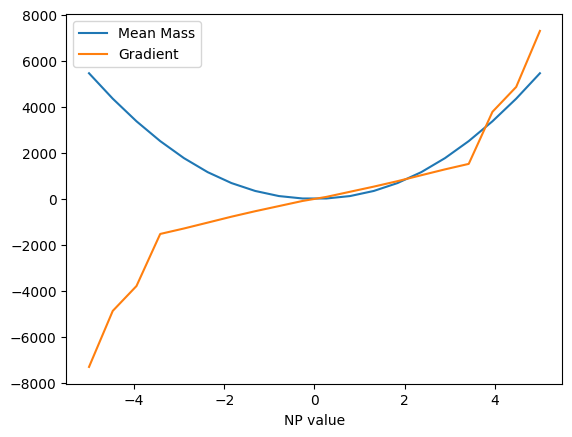

In [194]:
import jax.numpy as jnp

# plot mass means and gradient
np_vals = np.linspace(-5, 5, 20) 
vals_and_grads = np.array([jax.value_and_grad(pipeline, argnums=1)(jets, a) for a in np_vals])

mass_means = vals_and_grads[:, 0]
grads = vals_and_grads[:, 1]

fig, ax = plt.subplots()
ax.plot(np_vals, mass_means, label='Mean Mass')
ax.plot(np_vals, grads, label='Gradient')
ax.set_xlabel("NP value")
ax.set_ylabel("")
ax.legend()

In [ ]:
# we could now run gradient descent again, but there is nothing new from here on
# Next steps:
# - write more extensive test cases for category gradients (already found one bug that doesn't show up here)
# - add support for awkward arrays in correctionlib_gradients (maybe using the same workaround as above?)
